In [63]:
import keras_ocr
import cv2
import matplotlib.pyplot as plt
import numpy as np
import fitz  
from pathlib import Path
import tensorflow as tf
import gc
import pandas as pd
from docx import Document
gc.collect()
tf.keras.backend.clear_session()

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [64]:
def pdf_to_image(path):
    image = []
    path_to_save = "../data/Original_image/"
    pdf_path = path
    pdf_document = fitz.open(pdf_path)
    zoom: float = 5.0
    for page_num in range(len(pdf_document)):
        page = pdf_document[page_num]
        matrix = fitz.Matrix(zoom, zoom)  
        pixmap = page.get_pixmap(matrix=matrix)
        img_array = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, -1)
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        cv2.imwrite(path_to_save + str(page_num) + ".jpg", img_array)
        image.append(path_to_save + str(page_num) + ".jpg")
    return image

In [65]:


def extract_text_from_docx(docx_path):
    text_per_page = []
    doc = Document(docx_path)
    text =""
    for para in doc.paragraphs[1:]:
        para.text = para.text.replace("\n"," ")
        if para.text.strip().startswith("PDF p"):
           
           text_per_page.append(text)
           text =""
        else:
           text+=para.text           
    text_per_page.append(text)
    return text_per_page[1:]

# Usage
docx_text = extract_text_from_docx("../data/Text_transcription/Constituciones sinodales transcription.docx")

print(docx_text)  # Print or save the extracted text


['DON PHELIPPE POR LA Gracia de Dios, Rey de Castilla, de Leon, de Aragon, de las dos Sici- lias, de Hierusalem, de Portugal, de Navarra, de Granada, de Toledo,  de Valencia, de Galizia, de Mallorca,  de Sevilla, de Cerdeña, de Cordova,  de Corcega, de Murcia, de Jaen, de los Algarves, de Algecira, de Gibraltar, de las Islas de Canaria, de las Indias Orientales, y Occidentales, Islas y tierra firme del mar Oceano, Archiduque de Austria,  Duque de Borgoña, de Bravante, y Milan, Conde de Abs purg, de Flandes, y de Tirol, señor de Vizcaya, y de Mo- lina, &c. Por quanto por parte de vos, el Reverendo in Christo Padre, don Pedro Manso, Obispo de Calahorra,  y la Calzada, del nuestro Consejo: nos fue hecha relacion que en un Synodo que se havia hecho en la ciudad de Lo- grono, de esse Obispado, se havian hecho algunas Consti- tuciones Synodales, y reformadas las antiguas, y nos fue pedido, y suplicado os mandasemos dar licencia para que se imprimiessen las dichas constituciones, y lo pudiess

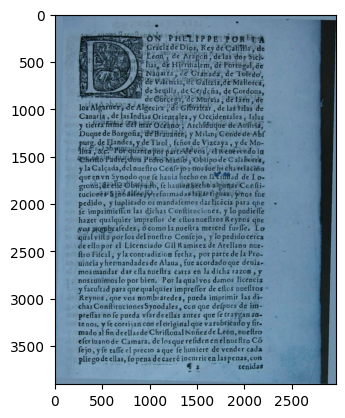

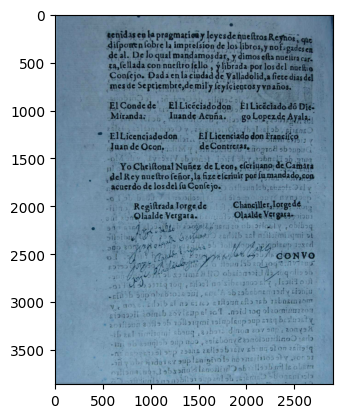

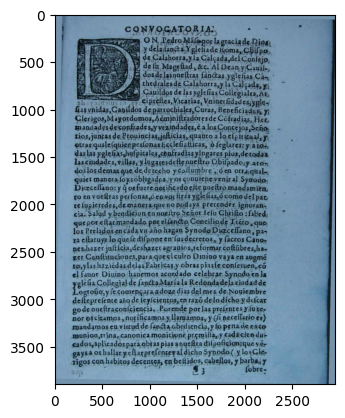

In [66]:
orignal_pdf=pdf_to_image("../data/Original_PDF/Constituciones sinodales Calahorra 1602.pdf")

for i in orignal_pdf[:3]:
    i=cv2.imread(i)
    plt.imshow(i)
    plt.show()

In [68]:
dicts={
    "image":orignal_pdf[:3],
    "text":docx_text
}

df=pd.DataFrame(dicts)
df["text"]=df["text"].apply(lambda x: x.replace("\n",""))
df.to_csv("../data/CSV/Constituciones_sinodales.csv",index=False)


In [69]:
df=pd.read_csv("../data/CSV/Constituciones_sinodales.csv")
df.head()

,image,text
0,../data/Original_image/0.jpg,"DON PHELIPPE POR LA Gracia de Dios, Rey de Cas..."
1,../data/Original_image/1.jpg,tenidas en la pragmatica y leyes de nuestros R...
2,../data/Original_image/2.jpg,DON Pedro Manso por la gracia de Dios y de la ...


Looking for C:\Users\91988\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\91988\.keras-ocr\crnn_kurapan.h5
9/9 [==============================] - 8s 780ms/step
['conyocatorin', 'on pedromalcpor la graciz de dios', 'ydelai ancta ygleliade komac cbifpo', 'de calahorraya calcadadel confejo', 'de lu mageitad xc al dean ycauils', 'dosde lasnucitras fanctas yglelias cans', 'thed rales de calahorray la cal caday', 'cauildos de las yglelias collegialsad', 'ci preites vicarias vniner fidadesygles', 'sb nn lns', 'gas vnidas caaildos de pattochiales curass beneficiades', 'y', 'clerigos malodomosaminitrdoes cofradias hes', 'mandades desonfadsyizindads e a los concejosscno', 'riosjuntas de prouinci asjafticias quanto a lo efpirifualzy', 'ptras qualquicinslati o iglares ya coa', 'daslas aopiscnrasinc piosdetodas', 'las ciudades villasylygaresdelt nueitro cbilfpadory', 'aton', 'dos los demas que de derecho ycoltumbre si 0 en otraqual', 'quier mancra lcysobligados yos conuicneveniral synodo', 'dicao

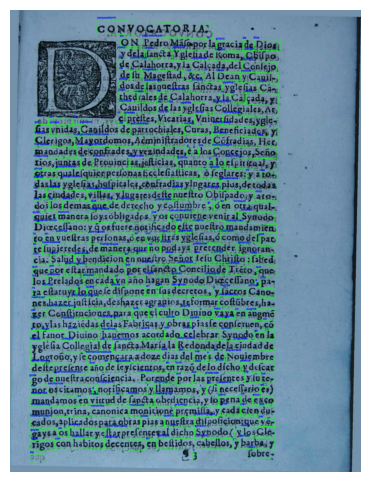

In [ ]:

# Ensure correct color conversion if needed
img_rgb = orignal_pdf[:3][-1]
img_rgb = cv2.imread(img_rgb)
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)

# Initialize Keras-OCR pipeline
pipeline = keras_ocr.pipeline.Pipeline()

# Run OCR prediction
predictions = pipeline.recognize([img_rgb])

# Store detected words with bounding box coordinates
detected_words = []
for text, box in predictions[0]:
    x_min = min([p[0] for p in box])  # Leftmost x-coordinate
    y_min = min([p[1] for p in box])  # Topmost y-coordinate
    detected_words.append((text, x_min, y_min, box))  # Store bounding box as well

# Step 1: Sort by y-coordinate (group by lines)
detected_words = sorted(detected_words, key=lambda x: x[2])  

# Step 2: Group words into lines based on y-coordinate proximity
lines = []
current_line = [detected_words[0]]

for i in range(1, len(detected_words)):
    if abs(detected_words[i][2] - current_line[-1][2]) < 20:  # Adjust threshold as needed
        current_line.append(detected_words[i])
    else:
        lines.append(current_line)
        current_line = [detected_words[i]]

lines.append(current_line)  # Append last line

# Step 3: Sort words within each line by x-coordinate
for line in lines:
    line.sort(key=lambda x: x[1])

# Step 4: Reconstruct sentences
resulted_text = [" ".join([word[0] for word in line]) for line in lines]

# Draw bounding boxes and words on the image
for line in lines:
    for word in line:
        text, _, _, box = word
        box = [(int(x), int(y)) for x, y in box]  
        cv2.polylines(img_rgb, [np.array(box)], isClosed=True, color=(0, 255, 0), thickness=2) 
        cv2.putText(img_rgb, text, (box[0][0], box[0][1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2, cv2.LINE_AA)

print(resulted_text)

# Display the processed image
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))  # Convert to RGB for correct colors
plt.axis("off")
plt.show()
